# ARIMA Models. Part 2: Use Case Walk Through

This notebook is the second part of the tutorial on ARIMA modeling for enterprise use cases. It describes the standard process for ARIMA and SARIMA modeling including initial time series valiation, model parameters selection, and fitting and forecasting.

---
# Step 1: Load and Filter Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')

from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [33]:
# This dataset is a daily series of sales quantities for several stores and items (products) for a time range of 5 years 
data = pd.read_csv('../resources/time-series/store-item-sales.zip', compression='zip', parse_dates=['date'], index_col='date')

In [64]:
# Take one series for store #1 and item #1
data = data.query('store == 1 & item == 1')

In [4]:
data.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='date', length=1826, freq=None)

In [5]:
ts = data['sales']

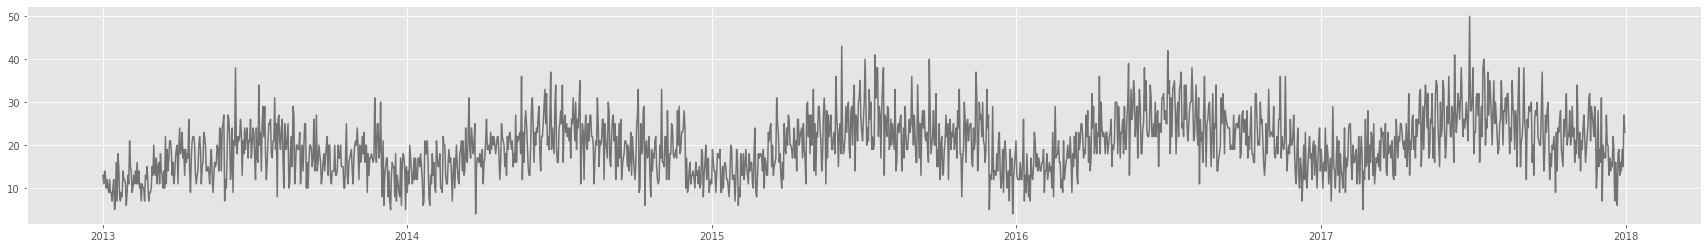

In [6]:
plt.figure(figsize=(30,4))
plt.plot(ts, color='black', alpha=0.5)
plt.show()

---
# Step 2: Analyze Data Properties and Feasibility

We first check whether the data is stationary, that is:
* The mean is constant
* The variance is constant
* Covarience doesn't depend on time (no trends or seasonality, but cycles can be present)

In [7]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, mean_window = 7, var_window = 7):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window = mean_window).mean()
    rolstd = timeseries.rolling(window = var_window).std()

    #Plot rolling statistics:
    plt.figure(figsize=(30,4))
    orig = plt.plot(timeseries, color='black', label='Original', alpha=0.5)
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='orange', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

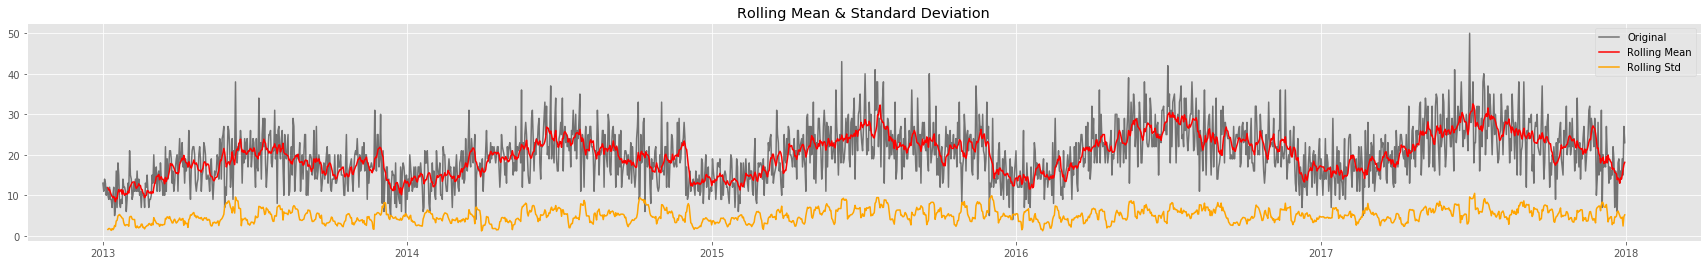

Dickey-Fuller Test:
Test Statistic                   -3.157671
p-value                           0.022569
#Lags Used                       23.000000
Number of Observations Used    1802.000000
Critical Value (1%)              -3.433984
Critical Value (5%)              -2.863145
Critical Value (10%)             -2.567625
dtype: float64


In [8]:
test_stationarity(ts)

* There is an upward trend, but variance stays relatively constant. 
* There are clear seasonal peaks in the middle of every year.

The next step is to differentiate the time series and assess the stationarity characteristics again.

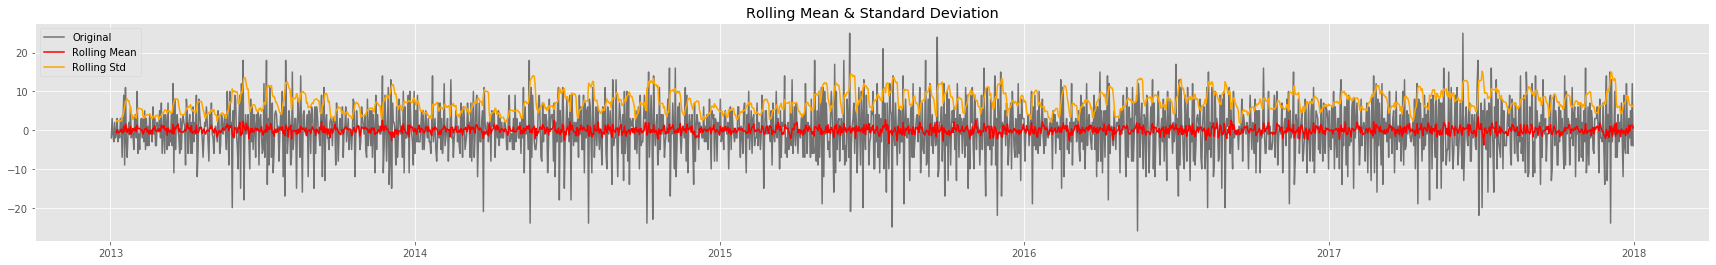

Dickey-Fuller Test:
Test Statistic                -1.267679e+01
p-value                        1.210928e-23
#Lags Used                     2.200000e+01
Number of Observations Used    1.802000e+03
Critical Value (1%)           -3.433984e+00
Critical Value (5%)           -2.863145e+00
Critical Value (10%)          -2.567625e+00
dtype: float64


In [9]:
ts_diff = ts - ts.shift(1)
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

Now the series looks stationary. The mean is constant, test statistic is below 1% and p-value is low. 

---
## Step 3: Parameter Estimation

The next step is to compute autocorrelation (ACF) and partial autocorrelation (PACF) functons. ACF/PACF properties will be used to pick proper ARIMA and SARIMA parameters p, d, q. Refer to Part 1 for a theoretical background. 

/Users/ikatsov/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


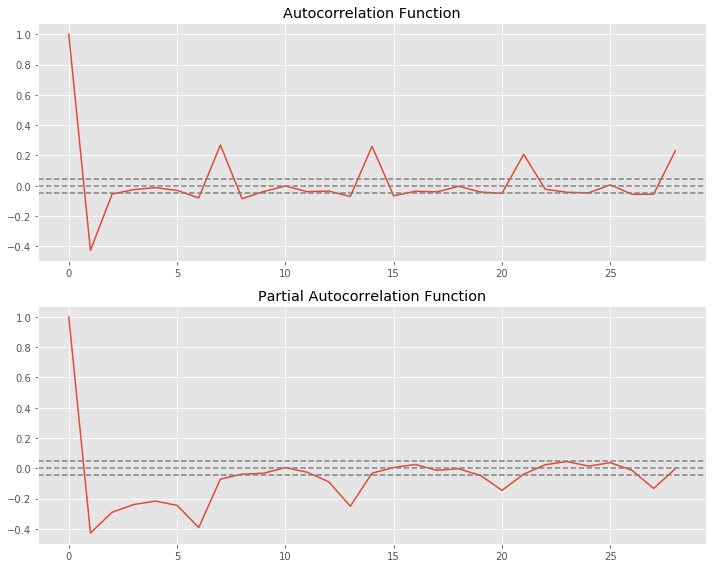

In [10]:
from statsmodels.tsa.stattools import acf, pacf

acf = acf(ts_diff, nlags=28)
pacf = pacf(ts_diff, nlags=28, method='ols')

fig, ax = plt.subplots(2, 1, sharey=True, figsize=(10, 8))

for i, (ac, ac_name) in enumerate([(acf, 'Autocorrelation Function'), (pacf, 'Partial Autocorrelation Function')]):
    ax[i].plot(ac)
    ci_boundary = 1.96/np.sqrt(len(ts_diff))
    for ci_line in [0, -ci_boundary, ci_boundary]:
        ax[i].axhline(y=ci_line, linestyle='--', color='gray')
    ax[i].title.set_text(ac_name)
    
plt.tight_layout()

We make the following choices for ARIMA model parameters:
* We choose the difference parameter d to be 1 based on the previous analysis that shown that the differenciated series is stationary.
* We set parameter p for AR(p) process to 7 becasue PACF cuts off at this point, except seasonal spikes.
* We set parameter q for MA(q) process to 2, based on the ACF. This exludes seasonal spikes as well.

---
## Step 4: Fitting ARIMA

In [11]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace import sarimax
from sklearn.metrics import mean_squared_error

In [12]:
arima_model = ARIMA(endog=ts, order=(7, 1, 2), freq='D').fit(disp = False)
fitted_values_arima = arima_model.predict(typ='levels')

Text(0.5, 1.0, 'MSE: 23.88')

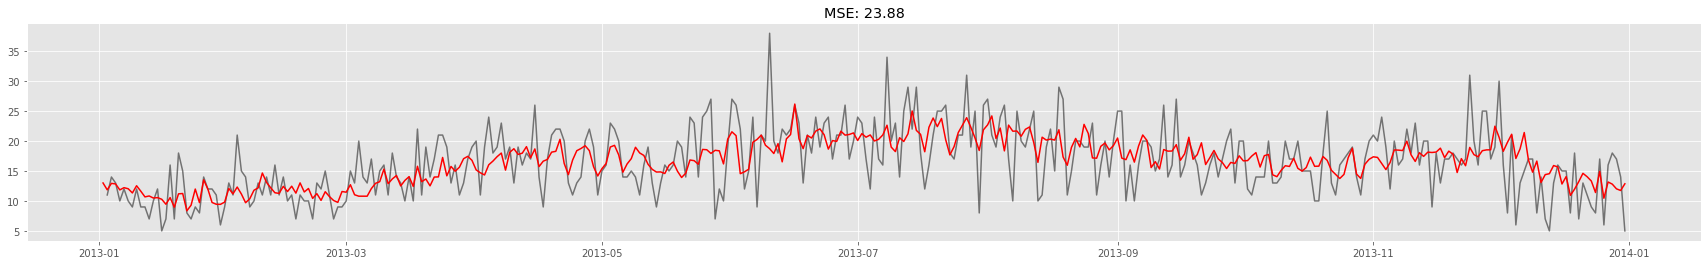

In [13]:
plt.figure(figsize=(30,4))
plt.plot(ts['2013'][1:].shift(), color='black', alpha=0.5)
plt.plot(fitted_values_arima['2013'], color='red')
mse = mean_squared_error(fitted_values_arima, ts.shift()[1:])
plt.title(f'MSE: {mse:.2f}')

---
## Step 5: Fitting SARIMAX

In [ ]:
sarimax_model = sarimax.SARIMAX(endog=ts, trend='c', freq='D', order=(7, 0, 2), seasonal_order=(1, 0, 1, 30)).fit(disp=False)
fitted_values_sarimax = sarimax_model.predict(typ='levels')

Text(0.5, 1.0, 'MSE: 23.61')

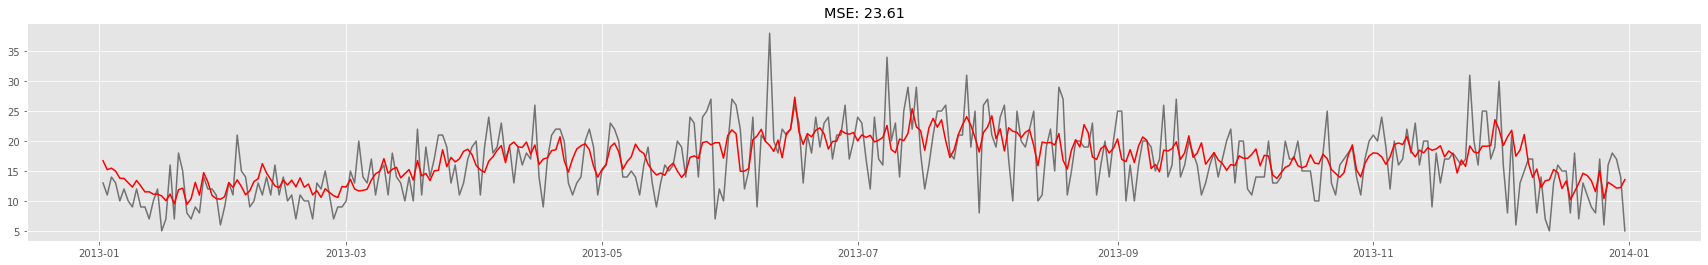

In [16]:
plt.figure(figsize=(30, 4))
plt.plot(ts['2013'].shift(), color='black', alpha=0.5)
plt.plot(fitted_values_sarimax['2013'][1:], color='red')
mse = mean_squared_error(fitted_values_sarimax[1:], ts.shift()[1:])
plt.title(f'MSE: {mse:.2f}')

---
## Step 6: Checking the Residuals

The next step is to check the distribution and autororrelation of the residuals.

NormaltestResult(statistic=23.018700632936216, pvalue=1.00358154696841e-05)


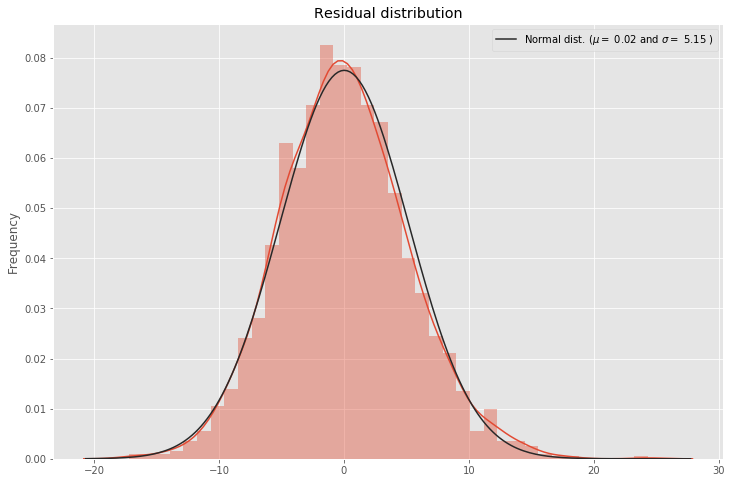

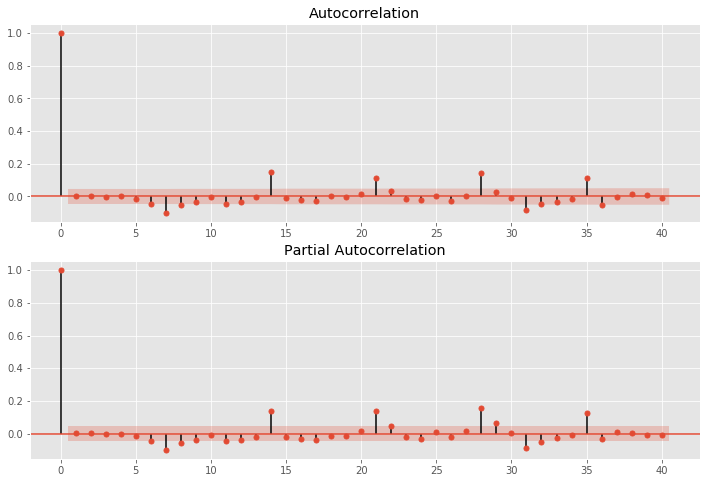

In [17]:
from scipy import stats
from scipy.stats import normaltest
import seaborn as sns
import statsmodels.api as sm

def plot_residuals(residuals): 
    print(normaltest(residuals))

    fig = plt.figure(figsize=(12,8))
    ax0 = fig.add_subplot(111)

    # Plot the distribution
    sns.distplot(residuals ,fit = stats.norm, ax = ax0)
    (mu, sigma) = stats.norm.fit(residuals)  
    plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
    plt.ylabel('Frequency')
    plt.title('Residual distribution')

    # ACF and PACF
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)
    
plot_residuals(sarimax_model.resid)

---
## Step 7: Out of Sample Forecasting

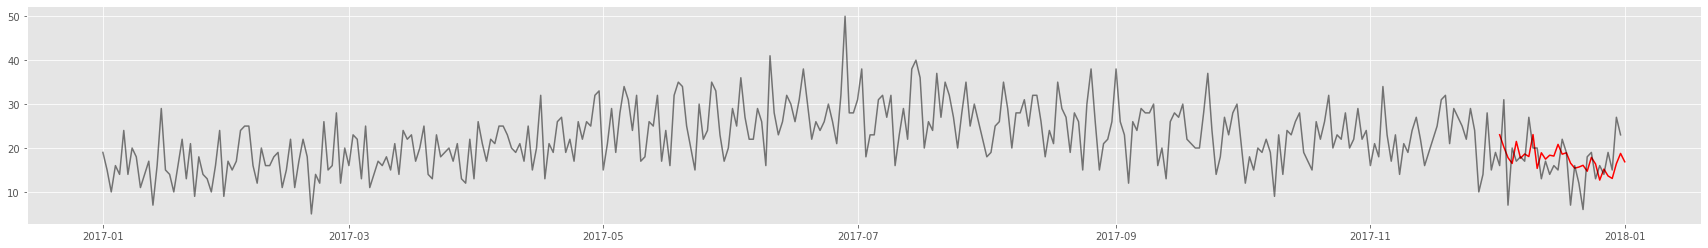

In [20]:
# In sample forecasting
n = len(sarimax_model.fittedvalues) 
predicted = sarimax_model.predict(n - 30, n)

plt.figure(figsize=(30, 4))
plt.plot(predicted, color='red')
plt.plot(ts['2017'], color='black', alpha=0.5)

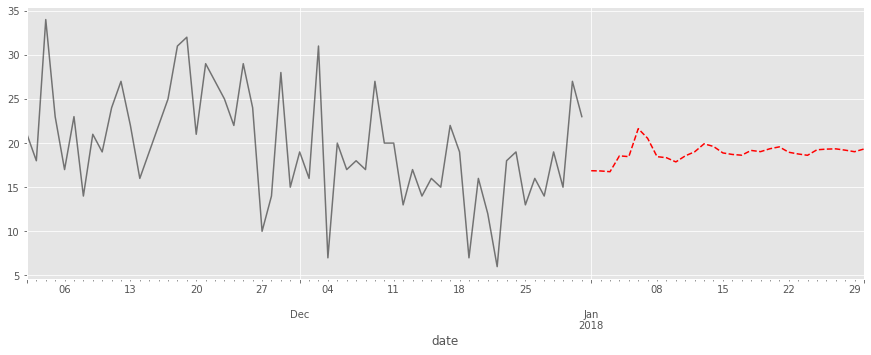

In [21]:
# Out of sample forecasting
fcast = sarimax_model.get_forecast(30).summary_frame()
fig, ax = plt.subplots(figsize=(15, 5))
ts[-60:].plot(ax = ax, color='black', alpha=0.5)
fcast['mean'].plot(ax = ax, style='r--')

---
## Step 8: Improving the Model Using Exogenous Features

The nest step is to improve the results using exogenous features like holidays, weekends, and pre/post holiday day indicators.

In [72]:
storeid = 1
itemid = 1
train_df = data.asfreq(freq ='D') 
train_df['date'] = train_df.index
train_df['year'] = train_df['date'].dt.year - 2012
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.dayofyear
train_df['weekday'] = train_df['date'].dt.weekday
train_df = train_df.set_index('date')

holiday = pd.read_csv('../resources/time-series/usholidays-1966-2020.csv', header=0, names = ['id','date', 'holiday'])
holiday['date'] = pd.to_datetime(holiday['date'], yearfirst = True, format = '%Y-%m-%d')

# remove unused holidays
holiday = holiday[holiday['date'] >= '2013-01-01']
holiday = holiday[holiday['date'] < '2018-01-01']

In [73]:
train_df = train_df.merge(holiday, how='left', on='date')
train_df['holiday_bool'] = pd.notnull(train_df['holiday']).astype(int)
train_df = pd.get_dummies(train_df, columns = ['month', 'holiday', 'weekday'] , prefix = ['month', 'holiday', 'weekday'])
train_df.head()

,date,store,item,sales,year,day,id,holiday_bool,month_1,month_2,...,holiday_Thanksgiving Day,holiday_Veterans Day,holiday_Washington's Birthday,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2013-01-01,1,1,13,1,1,20.0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
1,2013-01-02,1,1,11,1,2,NaN,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,2013-01-03,1,1,14,1,3,NaN,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,2013-01-04,1,1,13,1,4,NaN,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,2013-01-05,1,1,10,1,5,NaN,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [74]:
exog_data = train_df.drop(columns=['sales', 'id'], inplace=False, axis=1)
exog_data = exog_data.set_index('date')
train_df = train_df.set_index('date')

In [ ]:
sarimax_exog_model = sm.tsa.statespace.SARIMAX(endog = train_df.sales,
                                        exog = exog_data,  
                                        trend='n', 
                                        order=(7, 0, 2), 
                                        seasonal_order=(1, 0, 1, 30)).fit()

fitted_values_sarimax_exog = sarimax_exog_model.predict(typ='levels')

Text(0.5, 1.0, 'MSE: SARIMAX Endogenous 21.08, SARIMAX Exogeneous: 28.69')

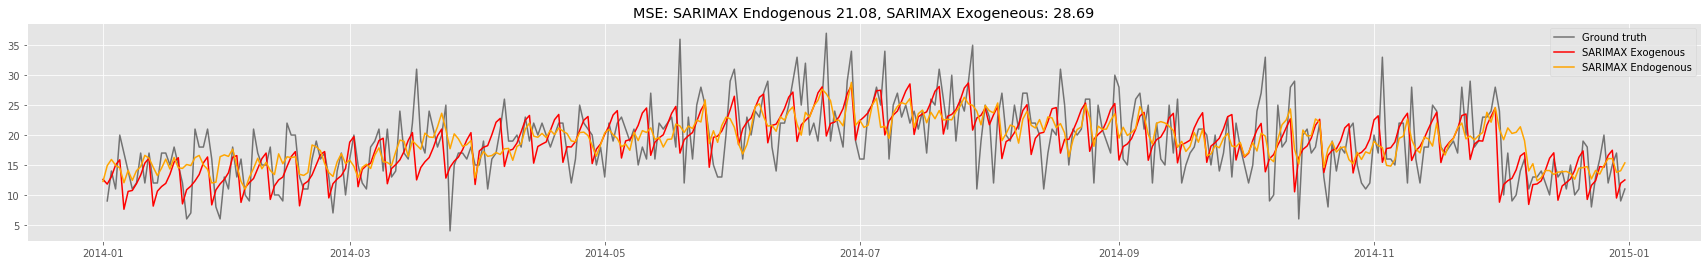

In [76]:
plot_year = '2014'
plt.figure(figsize=(30, 4))
plt.plot(ts[plot_year].shift(), color='black', alpha=0.5, label='Ground truth')
plt.plot(fitted_values_sarimax_exog[plot_year], color='red', label='SARIMAX Exogenous')
plt.plot(fitted_values_sarimax[plot_year], color='orange', label='SARIMAX Endogenous')
plt.legend()
mse_endog = mean_squared_error(fitted_values_sarimax[plot_year][1:], ts[plot_year].shift()[1:])
mse_exog = mean_squared_error(fitted_values_sarimax_exog[plot_year][1:], ts[plot_year].shift()[1:])
plt.title(f'MSE: SARIMAX Endogenous {mse_endog:.2f}, SARIMAX Exogeneous: {mse_exog:.2f}')

Note that we have a much more regular and meanigful structure aligned with weekly cycles for the model with exogenous features.

---
## Step 9: Checking the Residual

Finally, we check the residuals for SARIMAX model with exogenous features.

NormaltestResult(statistic=23.43101366273943, pvalue=8.166200344628717e-06)


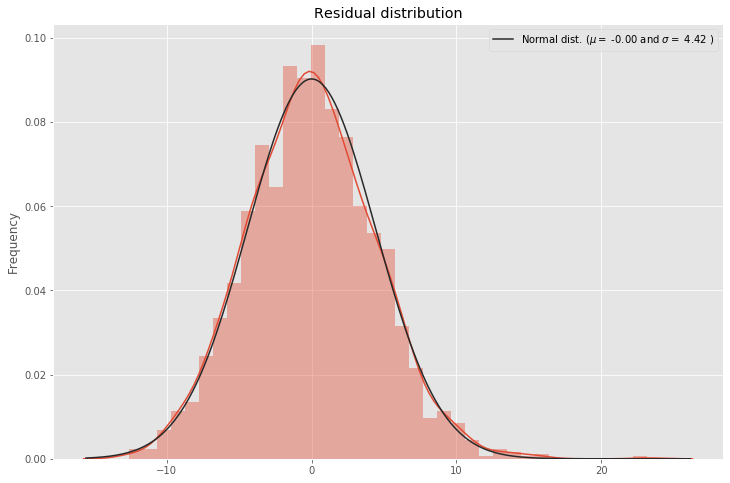

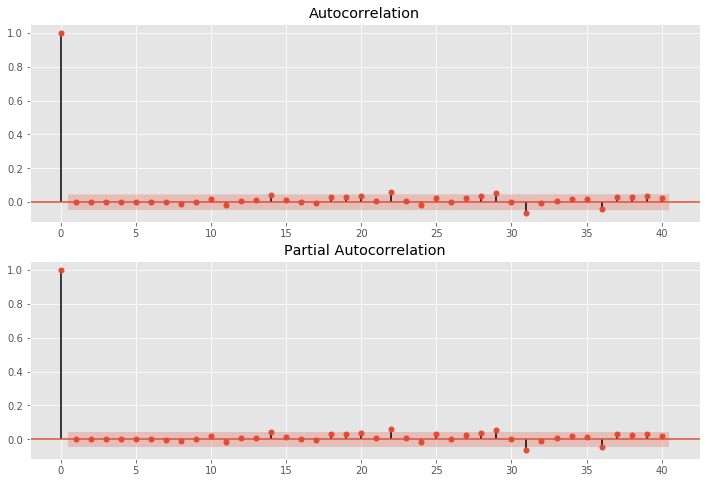

In [77]:
resid = plot_residuals(sarimax_exog_model.resid)